In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import tensorflow as tf
import tensorflow_hub as hub
import keras.backend as K
from keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Concatenate, Lambda, Flatten
from keras.models import Model
from keras.callbacks import EarlyStopping

In [2]:
df=pd.read_csv('reviews.csv')

In [8]:
df=df[~df['review_text'].isna()]

In [10]:
df.groupby('label').count() # there is class imbalance

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,review_id,app_id,review_text
label,,,,,,
0.0,299,299,280,299,299,299
1.0,1479,1479,1420,1479,1479,1479


In [24]:
list(df['review_text'])

['i can confirm that the game contains a knight that is mourning.\n10/10 recommended',
 'Really good game, enjoyed every second of it',
 'Its not finished yet but honestly it has great potential and could become a big game',
 "Hey. It's really good. Songs are good, Gameplay is alright. This is pretty good!",
 'Fun so far',
 "I'd rather play Warface then this. Horrible design Choices: 1. The Hud is a cluster fuck 2. You have a picture as a Scope (???) 3. Unlocking Operators takes forever 4. You respawn with the same amount of ammo you had before dying (???) 5. Ammo Boxes have a 5 minute cooldown 6. You only have 3 mags and it takes almost a full one to kill someone 7. You can only use your grenade/rpg once a match 8. Pretty much pay2win with the operators since you can just buy them, one has a one shot sniper 9. Horrible voice acting 10. You cant preview any Items 11. You can only pick 1 Item from a Lootbox and Finally 12. Bad Optimisation, i get more fps playing MW 2022.",
 "I have bee

In [11]:
# Load pre-trained language model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df["review_text"], df["label"], test_size=0.2, 
                                                    # stratify will make sure the labels are
                                                    # well proportioned in train and test
                                                    stratify=df["label"], random_state=42)


In [13]:
sum(y_train)/len(y_train) # check imbalance

0.8319268635724332

In [14]:
sum(y_test)/len(y_test) # check imbalance

0.8314606741573034

In [15]:
# Prepare data
X_train = [text.lower() for text in X_train] # convert to lowercase
X_test = [text.lower() for text in X_test] # convert to lowercase
X_train_embeddings = embed(X_train) # generate embeddings for train data
X_test_embeddings = embed(X_test) # generate embeddings for test data

In [16]:
X_train_embeddings.shape

TensorShape([1422, 512])

In [17]:
X_test_embeddings.shape

TensorShape([356, 512])

In [89]:
# Train logistic regression model
# change betweeen models to see difference
clf = LogisticRegression().fit(X_train_embeddings, y_train)
clf = SVC(kernel='linear', C=1, random_state=42).fit(X_train_embeddings, y_train)

# Make predictions on test set
y_pred = clf.predict(X_test_embeddings)

# Evaluate model
accuracy = clf.score(X_test_embeddings, y_test)

In [90]:
accuracy

0.8707865168539326

In [91]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 25,  35],
       [ 11, 285]])

In [25]:
# use deep learning

In [92]:
# Calculate the class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train),
                                     y= y_train)

class_weight_dict = dict(enumerate(class_weights))

Epoch 1/30
45/45 [==============================] - 4s 19ms/step - loss: 0.6495 - accuracy: 0.5098 - val_loss: 0.5726 - val_accuracy: 0.8118
Epoch 2/30
45/45 [==============================] - 0s 7ms/step - loss: 0.4954 - accuracy: 0.8115 - val_loss: 0.4562 - val_accuracy: 0.7809
Epoch 3/30
45/45 [==============================] - 0s 5ms/step - loss: 0.3750 - accuracy: 0.8312 - val_loss: 0.3955 - val_accuracy: 0.8146
Epoch 4/30
45/45 [==============================] - 0s 6ms/step - loss: 0.3257 - accuracy: 0.8467 - val_loss: 0.3754 - val_accuracy: 0.8315
Epoch 5/30
45/45 [==============================] - 0s 6ms/step - loss: 0.2900 - accuracy: 0.8678 - val_loss: 0.3836 - val_accuracy: 0.8202
Epoch 6/30
45/45 [==============================] - 0s 6ms/step - loss: 0.2672 - accuracy: 0.8706 - val_loss: 0.3830 - val_accuracy: 0.8202


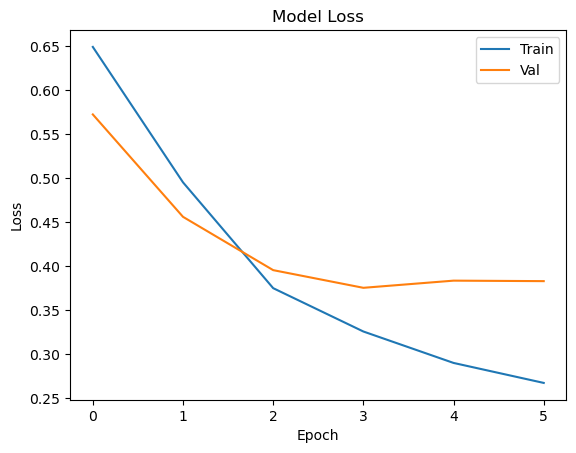

In [93]:
# Define the model
EMBEDDING_DIM= 512

input_layer = Input(shape=(1, EMBEDDING_DIM))
lstm_layer = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
attention = Dense(1, activation='tanh')(lstm_layer)
attention = Lambda(lambda x: K.softmax(x, axis=1))(attention)
context_vector = Concatenate(axis=-1)([lstm_layer, attention])
context_vector = Flatten()(context_vector)  # add this layer to reduce the dimensionality of the attention vector
output_layer = Dense(1, activation='sigmoid')(context_vector)
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# Train the model
history = model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test),
                    class_weight = class_weight_dict,
                    epochs=30, batch_size=32,
                   callbacks=[early_stopping])

# Plot the training and validation loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.show()

In [95]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print("Test Accuracy:", accuracy)

12/12 [==============================] - 0s 3ms/step - loss: 0.3830 - accuracy: 0.8202
Test Accuracy: 0.8202247023582458
